In [2]:
import os
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.utils.data
from torch.utils.data import Dataset, DataLoader

# --- CONFIGURATION ---
CONFIG = {
    "image_dir": "C:/DeepFashion-MultiModal/images", # Images
    "mask_dir": "C:/DeepFashion-MultiModal/segm", # Ground truth
    
    "subset_size": 10000, 
    
    "img_size": 256,      # Image resized for faster computation
    "batch_size": 8,      
    "epochs": 20,        
    "lr": 0.01,
    "device": "cuda" if torch.cuda.is_available() else "cpu" # Training on GPU for faster results
}

# Class Map
LABELS = {
    0: 'background', 1: 'top', 2: 'outer', 3: 'skirt', 
    4: 'dress', 5: 'pants', 6: 'leggings', 7: 'headwear', 
    8: 'eyeglass', 9: 'neckwear', 10: 'belt', 11: 'footwear', 
    12: 'bag', 13: 'hair', 14: 'face', 15: 'skin', 
    16: 'ring', 17: 'wrist wearing', 18: 'socks', 19: 'gloves', 
    20: 'necklace', 21: 'rompers', 22: 'earrings', 23: 'tie'
}

print(f"Configuration Loaded.")
print(f"Training Target: {CONFIG['subset_size']} Images")
print(f"Device: {CONFIG['device']}")

Configuration Loaded.
Training Target: 10000 Images
Device: cuda


In [3]:
# Dataset Class 

class DeepFashionRAMDataset(Dataset):
    def __init__(self, image_dir, mask_dir, img_size, limit=None):
        self.img_size = img_size
        self.images = [] # Storing actual pixels here
        self.masks = []
        
        # 1. Find Files
        valid_pairs = []
        if os.path.exists(image_dir):
            all_imgs = sorted(os.listdir(image_dir))
            for img_name in all_imgs:
                stem = os.path.splitext(img_name)[0]
                mask_name = f"{stem}_segm.png"
                if os.path.exists(os.path.join(mask_dir, mask_name)):
                    valid_pairs.append((os.path.join(image_dir, img_name), 
                                        os.path.join(mask_dir, mask_name)))
        
        # 2. Limit Data
        if limit and limit < len(valid_pairs):
            random.seed(42)
            random.shuffle(valid_pairs)
            valid_pairs = valid_pairs[:limit]
            
        print(f"Loading {len(valid_pairs)} images into RAM... ")
        
        # 3. Load Pixels into RAM 
        for i, (img_path, mask_path) in enumerate(valid_pairs):
            
            # Load & Resize Image
            img = Image.open(img_path).convert("RGB")
            img = img.resize((self.img_size, self.img_size))
            # Store as uint8 (0-255) 
            self.images.append(np.array(img)) 
            
            # Load & Resize Mask
            mask = Image.open(mask_path)
            mask = mask.resize((self.img_size, self.img_size), Image.NEAREST)
            self.masks.append(np.array(mask).astype(np.int64))
            
            # Progress print every 1000 images
            if (i+1) % 1000 == 0:
                print(f"   ... Loaded {i+1}/{len(valid_pairs)}")

        print("RAM Load Complete! Training will be fast now.")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # 1. Retrieve pixels from RAM 
        img_np = self.images[idx]
        mask_np = self.masks[idx]
        
        # 2. Convert to Tensor
        img_tensor = torch.tensor(img_np).float() / 255.0
        img_tensor = img_tensor.permute(2, 0, 1) # Channels first
        mask_tensor = torch.tensor(mask_np).long()
        
        return img_tensor, mask_tensor


# 1. Create the Dataset Object 
full_dataset = DeepFashionRAMDataset(
    image_dir=CONFIG["image_dir"],
    mask_dir=CONFIG["mask_dir"],
    img_size=CONFIG["img_size"],
    limit=CONFIG["subset_size"]
)

# 2. Split
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_set, val_set = torch.utils.data.random_split(full_dataset, [train_size, val_size])

# 3. Loaders 
train_loader = DataLoader(train_set, batch_size=CONFIG["batch_size"], shuffle=True)
val_loader = DataLoader(val_set, batch_size=CONFIG["batch_size"], shuffle=False)

print(f"Initialization Complete: {len(train_set)} Training | {len(val_set)} Validation")

Loading 10000 images into RAM... 
   ... Loaded 1000/10000
   ... Loaded 2000/10000
   ... Loaded 3000/10000
   ... Loaded 4000/10000
   ... Loaded 5000/10000
   ... Loaded 6000/10000
   ... Loaded 7000/10000
   ... Loaded 8000/10000
   ... Loaded 9000/10000
   ... Loaded 10000/10000
RAM Load Complete! Training will be fast now.
Initialization Complete: 8000 Training | 2000 Validation


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os


class DoubleConv(nn.Module):

    # Double convolution
    
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):

    # Max pooling and after double convolution

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    
    # Upscalling and after double convolution


    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        # Biliniar or transposed convolution, how the upscalling happens
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        # Double the size of x1
        x1 = self.up(x1)
        # Input is CHW
        # Safety check that the images have the same X and Y
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        # Adds black pixels to x1 to make it the same size as x2
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        
        # Concat the two
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNetFromScratch(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False): 
        super(UNetFromScratch, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNetFromScratch(n_channels=3, n_classes=24, bilinear=False).to(device)



weights_path = "best_model_10k1.pth" 
if os.path.exists(weights_path):
    try:
        model.load_state_dict(torch.load(weights_path, map_location=device))
        print(f"Success! Loaded weights from {weights_path}")
    except RuntimeError as e:
        print(f"Error loading: {e}")
else:
    print(f"Error: Could not find '{weights_path}'")


Success! Loaded weights from best_model_10k1.pth


In [ ]:
def train_one_epoch(model, loader, criterion, optimizer):
    model.train() # Set the model to training mode
    total_loss = 0
    n_batches = len(loader)
    
    for i, (images, masks) in enumerate(loader):
        # Move to GPU
        images, masks = images.to(CONFIG["device"]), masks.to(CONFIG["device"])
        
        optimizer.zero_grad() # Zero the gradients
        outputs = model(images) # Forward pass
        loss = criterion(outputs, masks) # Compute the loss
        loss.backward() # Backward pass
        optimizer.step() # Update model parameters
        
        total_loss += loss.item()
        
        # Print status every 50 batches
        if (i+1) % 50 == 0:
            print(f"Step {i+1}/{n_batches} | Loss: {loss.item():.4f}")
            
    return total_loss / n_batches

@torch.no_grad()
def validate(model, loader, criterion):
    model.eval()
    total_loss = 0
    for images, masks in loader:
        images, masks = images.to(CONFIG["device"]), masks.to(CONFIG["device"])
        outputs = model(images)
        loss = criterion(outputs, masks)
        total_loss += loss.item()
    return total_loss / len(loader)

# 1. Initialize
model = UNetFromScratch(n_channels=3,n_classes=len(LABELS)).to(CONFIG["device"])
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG["lr"])

best_loss = float("inf")

print(f"STARTING TRAINING ON 10,000 IMAGES ({CONFIG['device']})")
print("-" * 40)

for epoch in range(CONFIG["epochs"]):
    print(f"\nEPOCH {epoch+1}/{CONFIG['epochs']}")
    
    # Train
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer)
    
    # Validate
    val_loss = validate(model, val_loader, criterion)
    
    print(f"Epoch {epoch+1} Summary: Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    
    # Save
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), "best_model_10k1.pth")
        print("New Best Model Saved!")

Inspecting Image Index: 179
Model detected: ['top', 'pants', 'headwear', 'footwear', 'hair', 'face', 'skin', 'wrist wearing']


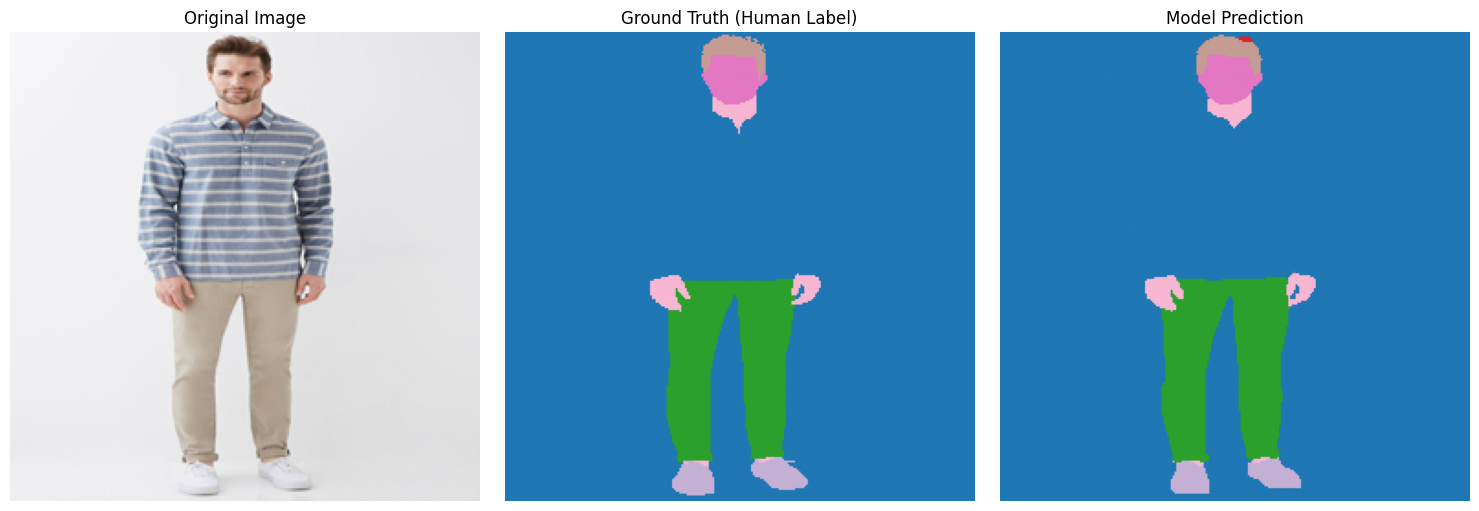

In [5]:
def predict_and_plot_random(model, dataset, device="cuda"):

    #  Pick Random Sample
    idx = random.randint(0, len(dataset) - 1)
    print(f"Inspecting Image Index: {idx}")
    
    # Get tensor data
    img_tensor, mask_tensor = dataset[idx]
    
    # 2. Prepare for Model
    # Add batch dimension: [3, 256, 256] -> [1, 3, 256, 256]
    input_tensor = img_tensor.unsqueeze(0).to(device)
    
    # 3. Predict
    model.eval()
    with torch.no_grad():
        
        logits = model(input_tensor)
        # Get class ID with highest score for each pixel
        pred_mask = torch.argmax(logits, dim=1).squeeze().cpu().numpy()
        
    # 4. Prepare for Plotting
    # Image: [3, 256, 256] -> [256, 256, 3] (Channels last for Matplotlib)
    img_np = img_tensor.permute(1, 2, 0).numpy()
    gt_mask_np = mask_tensor.numpy()
    
    # 5. List Detected Classes
    found_ids = np.unique(pred_mask)
    found_names = [LABELS[i] for i in found_ids if i != 0] # Skip background
    print(f"Model detected: {found_names}")

    # 6. Plot
    plt.figure(figsize=(15, 5))
    
    # Original
    plt.subplot(1, 3, 1)
    plt.imshow(img_np)
    plt.title("Original Image")
    plt.axis("off")
    
    # Ground Truth
    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask_np, cmap="tab20", vmin=0, vmax=23)
    plt.title("Ground Truth (Human Label)")
    plt.axis("off")
    
    # Prediction
    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask, cmap="tab20", vmin=0, vmax=23)
    plt.title("Model Prediction")
    plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# --- RUN IT ---
predict_and_plot_random(model, val_set, device=CONFIG["device"])

In [6]:
import numpy as np
import math
from collections import Counter

def fill_holes_knn_simple(pred_mask, max_prob, threshold=0.85, k=7):
    h, w = pred_mask.shape
    
    # 1. Create lists of coordinates manually
    confident_pixels = []  # Will store (y, x, label)
    uncertain_pixels = []  # Will store (y, x)
    
    print("Step 1: finding pixels...")
    # Loop through every single pixel in the image
    for y in range(h):
        for x in range(w):
            prob = max_prob[y, x]
            label = pred_mask[y, x]
            
            if prob >= threshold:
                # This pixel is good. It gets to vote.
                confident_pixels.append((y, x, label))
            else:
                # This pixel is bad. It needs fixing.
                uncertain_pixels.append((y, x))
    
    # If no holes, just return
    if len(uncertain_pixels) == 0:
        return pred_mask

    print(f"Step 2: Calculating distances for {len(uncertain_pixels)} pixels.")
    
    # Copy the mask so we don't change the original while working
    final_mask = pred_mask.copy()
    
    # 2. Loop through every uncertain pixel
    for i, (uy, ux) in enumerate(uncertain_pixels):
        
        # Determine progress every 100 pixels
        if i % 100 == 0:
            print(f"Processing pixel {i}/{len(uncertain_pixels)}...")

        distances = []
        
        # 3. Measure distance to EVERY confident pixel
        for (cy, cx, clabel) in confident_pixels:
            # Euclidean distance: sqrt((y2-y1)^2 + (x2-x1)^2)
            dist = math.sqrt((uy - cy)**2 + (ux - cx)**2)
            distances.append((dist, clabel))
        
        # 4. Sort by distance (smallest distance first)
        # We use a lambda to tell it to sort by the first item (dist)
        distances.sort(key=lambda x: x[0])
        
        # 5. Get the top K neighbors
        k_nearest = distances[:k]
        
        # 6. Collect the votes (the labels)
        votes = [label for (dist, label) in k_nearest]
        
        # 7. Find the most common vote
        # Counter creates a dictionary like {0: 2 votes, 1: 5 votes}
        vote_counts = Counter(votes)
        # most_common(1) returns [(label, count)]
        winner = vote_counts.most_common(1)[0][0]
        
        # 8. Assign the winner to the mask
        final_mask[uy, ux] = winner
        
    return final_mask

In [ ]:
import cv2

def analyze_garments_with_knn_and_save(model, dataset, device="cuda", threshold=0.85, k=7, output_root="output_masks"):
    """
    Picks a random image from the validation dataset, applies KNN, and saves results.
    """
    idx = random.randint(0, len(dataset) - 1)
    print(f"Analyzing Dataset Index: {idx}")
    
    # Get Image AND Ground Truth Mask
    img_tensor, mask_tensor = dataset[idx]
    
    # Prepare Input
    input_tensor = img_tensor.unsqueeze(0).to(device)
    
    # Model Prediction
    model.eval()
    with torch.no_grad():
        logits = model(input_tensor)
        probs = F.softmax(logits, dim=1)
        max_prob, pred_mask = torch.max(probs, dim=1)
        
        pred_mask = pred_mask.squeeze().cpu().numpy()
        max_prob = max_prob.squeeze().cpu().numpy()
        
    # KNN Refinement 
    refined_mask = fill_holes_knn_simple(pred_mask, max_prob, threshold=threshold, k=k)
    
    # Filter Results 
    found_ids = np.unique(refined_mask)
    garment_ids = [i for i in found_ids if i != 0] 
    
    if len(garment_ids) == 0:
        print("No items found.")
        return
    print(f"Found {len(garment_ids)} items.")
    
    # Save & Visualize
    folder_name = f"dataset_idx_{idx}"
    save_dir = os.path.join(output_root, folder_name)
    os.makedirs(save_dir, exist_ok=True)
    
    # Handle Image (Denormalize/Convert)
    img_np = img_tensor.permute(1, 2, 0).cpu().numpy()
    img_bgr = cv2.cvtColor((img_np * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)
    cv2.imwrite(os.path.join(save_dir, "original_image.jpg"), img_bgr)
    
    gt_mask_np = mask_tensor.numpy()

    # Plotting
    num_rows = 1 + len(garment_ids)
    cols = 4 
    plt.figure(figsize=(20, 4 * num_rows)) 
    
    # Overview Row
    plt.subplot(num_rows, cols, 1); plt.imshow(img_np); plt.title("Original"); plt.axis("off")
    plt.subplot(num_rows, cols, 2); plt.imshow(gt_mask_np, cmap='tab20', vmin=0, vmax=23); plt.title("Ground Truth"); plt.axis("off")
    
    raw_viz = pred_mask.copy()
    raw_viz[max_prob < threshold] = 0 
    plt.subplot(num_rows, cols, 3); plt.imshow(raw_viz, cmap='tab20', vmin=0, vmax=23); plt.title("Raw Output"); plt.axis("off")
    plt.subplot(num_rows, cols, 4); plt.imshow(refined_mask, cmap='tab20', vmin=0, vmax=23); plt.title(f"KNN Refined (k={k})"); plt.axis("off")
    
    # Individual Items
    for i, class_id in enumerate(garment_ids):
        row_idx = i + 1
        class_name = LABELS[class_id] if 'LABELS' in globals() and class_id < len(LABELS) else f"class_{class_id}"
        
        binary_mask = (refined_mask == class_id).astype(np.uint8)
        extracted = img_np * binary_mask[:, :, np.newaxis]
        
        cv2.imwrite(os.path.join(save_dir, f"{class_name}_mask.png"), binary_mask * 255)

        plt.subplot(num_rows, cols, (row_idx * cols) + 2); plt.imshow(binary_mask, cmap='gray'); plt.title(f"{class_name} Mask"); plt.axis("off")
        plt.subplot(num_rows, cols, (row_idx * cols) + 3); plt.imshow(extracted); plt.title(f"{class_name} Extracted"); plt.axis("off")
        
    plt.tight_layout()
    plt.show()


analyze_garments_with_knn_and_save(
    model=model,            
    dataset=val_set,        
    device="cuda",          
    threshold=0.85,        
    k=7,                   
    output_root="my_results" 
)

Analyzing Dataset Index: 33
Step 1: finding pixels...
Step 2: Calculating distances for 2044 pixels.
Processing pixel 0/2044...
Processing pixel 100/2044...
Processing pixel 200/2044...
Processing pixel 300/2044...


Analyzing image: unnamed...
  KNN: Refining 41987 uncertain pixels...
Found 6 items.


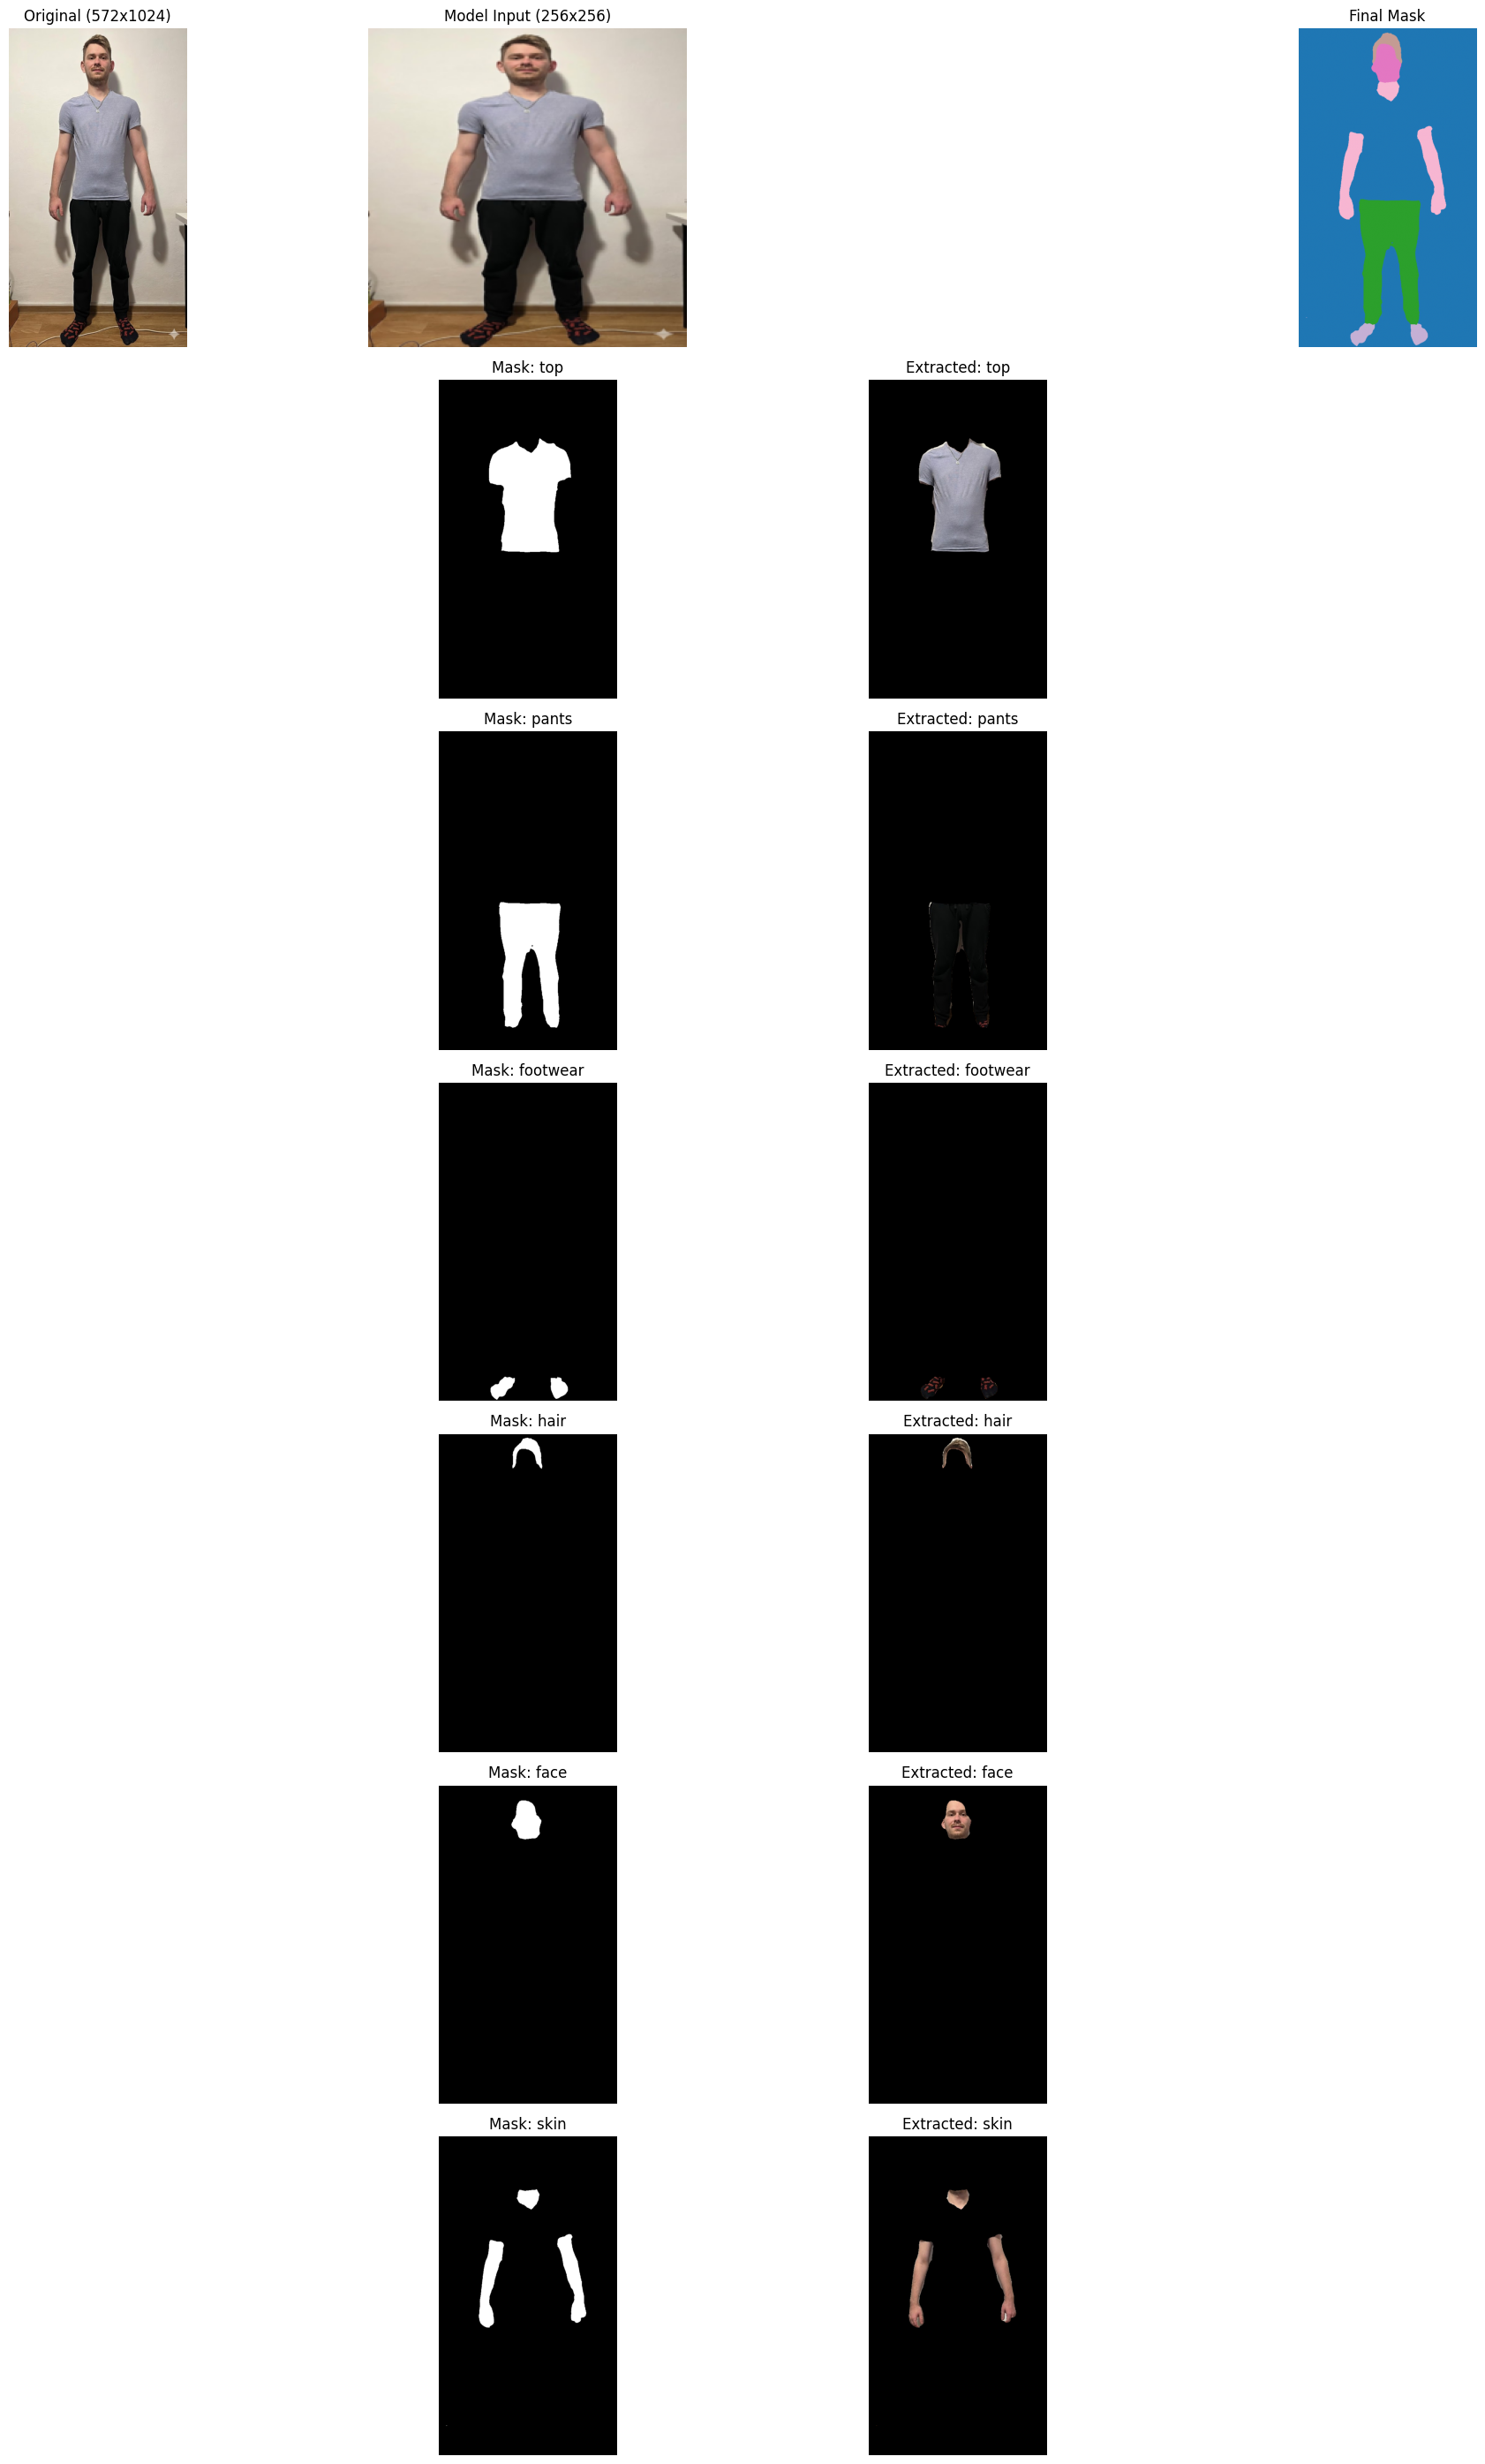

Results saved to output_masks\unnamed


In [ ]:
import os
import cv2
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

def analyze_single_image_with_knn_and_save(model, image_input, device="cuda", threshold=0.90, k=7, output_root="output_masks"):
    
    # --- 1. Load Image ---
    if isinstance(image_input, str):
        if not os.path.exists(image_input):
            print(f"Error: File {image_input} not found.")
            return
        filename = os.path.basename(image_input).split('.')[0]
        original_img_bgr = cv2.imread(image_input)
        original_img_rgb = cv2.cvtColor(original_img_bgr, cv2.COLOR_BGR2RGB)
    elif isinstance(image_input, np.ndarray):
        filename = "custom_input_array"
        original_img_rgb = image_input
        original_img_bgr = cv2.cvtColor(image_input, cv2.COLOR_RGB2BGR)
    else:
        print("Error: Input type not supported.")
        return

    # Keep original dimensions
    orig_h, orig_w = original_img_rgb.shape[:2]


    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((256, 256)), # You said your images are 256x256
        transforms.ToTensor(),         # Converts to [0, 1] float (matches your / 255.0)
        # NO NORMALIZE HERE because your training didn't use it!
    ])
    
    input_tensor = transform(original_img_rgb).unsqueeze(0).to(device)

    print(f"Analyzing image: {filename}...")

    # --- 3. Model Inference ---
    model.eval()
    with torch.no_grad():
        logits = model(input_tensor)
        probs = F.softmax(logits, dim=1)
        
        # Resize output back to ORIGINAL image size
        probs_orig = F.interpolate(probs, size=(orig_h, orig_w), mode='bilinear', align_corners=False)
        
        # Get final mask
        max_prob, pred_mask = torch.max(probs_orig, dim=1)
        
        pred_mask = pred_mask.squeeze().cpu().numpy()
        max_prob = max_prob.squeeze().cpu().numpy()

    # --- 4. KNN Refinement ---
    refined_mask = fill_holes_knn_simple(pred_mask, max_prob, threshold=threshold, k=k)

    # --- 5. Filter Results ---
    found_ids = np.unique(refined_mask)
    garment_ids = [i for i in found_ids if i != 0]

    if len(garment_ids) == 0:
        print("No items found.")
        return

    print(f"Found {len(garment_ids)} items.")

    # --- 6. Save & Visualize ---
    save_dir = os.path.join(output_root, filename)
    os.makedirs(save_dir, exist_ok=True)
    cv2.imwrite(os.path.join(save_dir, "original_image.jpg"), original_img_bgr)

    num_rows = 1 + len(garment_ids)
    cols = 4
    plt.figure(figsize=(20, 4 * num_rows))

    # Row 1: Overview
    plt.subplot(num_rows, cols, 1)
    plt.imshow(original_img_rgb)
    plt.title(f"Original ({orig_w}x{orig_h})")
    plt.axis("off")

    # Show what the model saw
    debug_input = input_tensor.squeeze().cpu().permute(1,2,0).numpy()
    
    plt.subplot(num_rows, cols, 2)
    plt.imshow(debug_input) 
    plt.title("Model Input (256x256)")
    plt.axis("off")

    plt.subplot(num_rows, cols, 4)
    plt.imshow(refined_mask, cmap='tab20', vmin=0, vmax=23)
    plt.title(f"Final Mask")
    plt.axis("off")

    # Rows 2+: Items
    img_float = original_img_rgb.astype(np.float32) / 255.0

    for i, class_id in enumerate(garment_ids):
        row_idx = i + 1
        class_name = LABELS[class_id] if 'LABELS' in globals() and class_id < len(LABELS) else f"class_{class_id}"
        
        binary_mask = (refined_mask == class_id).astype(np.uint8)
        extracted = img_float * binary_mask[:, :, np.newaxis]

        mask_filename = f"{class_name}_mask.png"
        cv2.imwrite(os.path.join(save_dir, mask_filename), binary_mask * 255)

        plt.subplot(num_rows, cols, (row_idx * cols) + 2)
        plt.imshow(binary_mask, cmap='gray')
        plt.title(f"Mask: {class_name}")
        plt.axis("off")

        plt.subplot(num_rows, cols, (row_idx * cols) + 3)
        plt.imshow(extracted)
        plt.title(f"Extracted: {class_name}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()
    print(f"Results saved to {save_dir}")

analyze_single_image_with_knn_and_save(model, "unnamed.jpg", device="cuda")